In [1]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
plt.figure();
import mplhep
plt.style.use(mplhep.style.CMS)
#mplhep.style.use("CMS")


<Figure size 432x288 with 0 Axes>

In [2]:

allowedCapSelectVals=np.array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
                                 13,  14,  15,  24,  25,  26,  27,  28,  29,  30,  31,  56,  57,
                                 58,  59,  60,  61,  62,  63, 120, 121, 122, 123, 124, 125, 126,
                                 127, 248, 249, 250, 251, 252, 253, 254, 255, 504, 505, 506, 507,
                                 508, 509, 510, 511])
allowedCapSelectVals_map=np.zeros(512,dtype=int)
for i,j in enumerate(allowedCapSelectVals):
    allowedCapSelectVals_map[j]=i

IRRADIATION_START_TIME=np.datetime64('2022-09-30 08:20')

In [3]:
def parseLogFile(fName):
    _f=open(f'../../logs/{fName}')
    _fLines=_f.read()
    
    matches=re.findall(r'([019]*)-(.*) INFO   Power: On, Voltage: (.*) V, Current: (.*) A, Temp: (.*) C, Res.: (.*) Ohms\n\1.* Word count (\d*), error count (\d*)',_fLines)
    matches=np.array(matches)

    output={}
    dates=pd.to_datetime([x[0]+'-'+x[1] for x in matches[:,:2]])
    voltage=np.float32(matches[:,2])
    current=np.float32(matches[:,3])
    temp=np.float32(matches[:,4])
    rtd_resistance=np.float32(matches[:,5])
    badReadings=(voltage==-1)&(current==-1)
    voltage[badReadings]=np.nan
    current[badReadings]=np.nan
    badReadings=(temp==-1)&(rtd_resistance==-1)
    temp[badReadings]=np.nan
    rtd_resistance[badReadings]=np.nan
    comparisons=np.float32(matches[:,6])
    errors=np.float32(matches[:,7])
    errorRate=errors/comparisons
    
    matches=re.findall(r'([019]*)-.* RW M.*\n\1-(.*) INFO   Power: On, Voltage: (.*) V, Current: (.*) A, Temp: (.*) C, Res.: (.*) Ohms\n\1.* Word count (\d*), error count (\d*)',_fLines)
    matches=np.array(matches)
    datesI2C=pd.to_datetime([x[0]+'-'+x[1] for x in matches[:,:2]])
    isI2C=dates.isin(datesI2C)

    matches2=re.findall(r'([019]*)-.* RW M.*\n\1.*ERROR  Unable to reconnect to GPIB.*\n\1-(.*) INFO   Power: On, Voltage: (.*) V, Current: (.*) A, Temp: (.*) C, Res.: (.*) Ohms\n\1.* Word count (\d*), error count (\d*)',_fLines)
    matches2=np.array(matches2)
    if len(matches2)>0:
        datesI2C_2=pd.to_datetime([x[0]+'-'+x[1] for x in matches2[:,:2]])
        isI2C=np.bitwise_or(dates.isin(datesI2C) , dates.isin(datesI2C_2))
    
    t0=((dates.values-IRRADIATION_START_TIME).astype(int)/3.6e12)
    t0[t0<0]=0
    TID=t0*5.51

#     matches=re.findall(r'([019]*)-.* RW M.*\n09-(.*) INFO   Power: On, Voltage: (.*) V, Current: (.*) A, Temp: (.*) C, Res.: (.*) Ohms')
#     matches=np.array(matches)
#     voltage=np.float32(matches[:,2])
#     current=np.float32(matches[:,3])
#     temp=np.float32(matches[:,4])
#     rtd_resistance=np.float32(matches[:,5])
#     badReadings=(voltage==-1)&(current==-1)
#     voltage[badReadings]=np.nan
#     current[badReadings]=np.nan
#     badReadings=(temp==-1)&(rtd_resistance==-1)
#     temp[badReadings]=np.nan
#     rtd_resistance[badReadings]=np.nan

#     dates2=pd.to_datetime([x[0]+'-'+x[1] for x in matches[:,:2]])
#     t0=((dates.values-IRRADIATION_START_TIME).astype(int)/3.6e12)
#     t0[t0<0]=0
#     TID=t0*5.51

    
    
    output['time']=dates
    output['TID']=TID
    output['voltage']=voltage
    output['current']=current
    output['temp']=temp
    output['rtd']=rtd_resistance
    output['nComp']=comparisons
    output['nErr']=errors
    output['isI2C']=isI2C
    
    re_string="([019]+)-(.*) INFO   Good PLL settings V=(.*): \[(.*)\]"

    matches=re.findall(re_string,_fLines)
    matches=np.array(matches)
    output['PLLscan_time']=pd.to_datetime([x[0]+'-'+x[1] for x in matches[:,:2]])
    output['PLLscan_voltage']=np.float32(matches[:,2])
#     output['PLLscan_nGoodSettings']=np.array([len(eval(x[2])) for x in matches])
#     output['PLLscan_minGoodSetting']=np.array([min(eval(x[2])) for x in matches])
#     output['PLLscan_maxGoodSettings']=np.array([max(eval(x[2])) for x in matches])

    t0=(output['PLLscan_time'].values-IRRADIATION_START_TIME).astype(int)/3.6e12
    t0[t0<0]=0
    TID=t0*5.51
    output['PLLscan_TID']=TID

    re_string="([019]+)-(.*) INFO   Good PLL settings V=(.*):|([019]+)-(.*) INFO.     CapSel=(\d+), V=(.*), PUSM=(\d)"
    matches=re.findall(re_string,_fLines)
    matches=np.array(matches)

    dates=[]
    pllFull=[]
    pll=[]
    v=[]
    for m in matches:
        if not m[0]=='':
            time=m[0]+'-'+m[1]
            dates.append(time)
            v.append(float(m[2]))
            pllFull.append([])
            pll.append([])
        else:
            pllFull.append(int(m[-3]))
            if m[-1]=='9':
                pll[-1].append(int(m[-3]))

# #     output['PLLscan_time']=[]
# #     output['PLLscan_voltage']=[]
#     output['PLLscan_nGoodSettings']=[]
#     output['PLLscan_minGoodSetting']=[]
#     output['PLLscan_maxGoodSettings']=[]
#     output['PLLscan_choice']=[]
#     for i in range(len(dates)):
# #         output['PLLscan_time'].append(dates[i])
# #         output['PLLscan_voltage'].append(v[i])
#         output['PLLscan_nGoodSettings'].append(len(pll[i]))
#         if len(pll[i])>0:
#             output['PLLscan_maxGoodSettings'].append(max(pll[i]))
#             output['PLLscan_minGoodSetting'].append(min(pll[i]))
#             j=int(len(pll[i])/3)
#             output['PLLscan_choice'].append(pll[i][j])
#         else:
#             output['PLLscan_maxGoodSettings'].append(-1)
#             output['PLLscan_minGoodSetting'].append(-1)
#             output['PLLscan_choice'].append(-1)
#     output['PLLscan_minGoodSetting']=np.array(output['PLLscan_minGoodSetting'])
#     output['PLLscan_choice']=np.array(output['PLLscan_choice'])
#     output['PLLscan_maxGoodSettings']=np.array(output['PLLscan_maxGoodSettings'])

# #     output['PLLscan2_time']=pd.to_datetime(np.array(output['PLLscan2_time']))

#     re_string='09-(.*) INFO   Setting PLL VCO CapSelect to (\d*) with phaseSelect settings of (\d*),(\d*),(\d*),(\d*),(\d*),(\d*),(\d*),(\d*),(\d*),(\d*),(\d*),(\d*)'
#     matches=re.findall(re_string,_fLines)
#     matches=np.array(matches)
#     output['PLLscan_used']=np.ones_like(output['PLLscan_time'],dtype=int)-2
#     output['PLLscan_used'][output['PLLscan_voltage']==1.2] = matches[:,1]
#     output['PLLscan_bestPhase'] = np.ones(len(output['PLLscan_time'])*12,dtype=int).reshape(-1,12)-2
#     output['PLLscan_bestPhase'][output['PLLscan_voltage']==1.2] = matches[:,2:]


#     re_string="09(.*) INFO.  Starting Power Scans \( timestamp (.*) \)"
#     matches=re.findall(re_string,_fLines)
#     matches=np.array(matches)
#     output['PLL_timestamp_time']=pd.to_datetime(['09-'+x for x in matches[:,0]])
#     output['PLL_timestamp']=np.array(matches[:,1])
# #     pd.to_datetime(['09-'+x for x in matches[:,0]])
# #     output['']
    return output
    

In [4]:
startIrr=parseLogFile('logFile_Chip09_StartIrradiation.log')
startIrr_2=parseLogFile('logFile_Chip09_17h48_StartIrradiation.log')
startIrr_3=parseLogFile('logFile_Chip09_Oct2_09h48_StartIrradiation.log')
startIrr_4=parseLogFile('logFile_Chip09_Oct2_12h26_StartIrradiation.log')
startIrr_5=parseLogFile('logFile_Chip09_Oct2_12h58_StartIrradiation.log')
startIrr_6=parseLogFile('logFile_Chip09_Oct2_19h03_StartIrradiation.log')

In [5]:
dfList=[]
for d in [startIrr,startIrr_2,startIrr_3,startIrr_4,startIrr_5,startIrr_6]:#,IrrSept28_v4,IrrSept28_v5,IrrSept28_v6,IrrSept28_v8,IrrSept28_v9]:
    dfList.append(pd.DataFrame({x:d[x] for x in ['TID', 'voltage', 'current', 'temp', 'rtd', 'nComp', 'nErr', 'isI2C']},index=d['time']))
dfErr=pd.concat(dfList)


<AxesSubplot:>

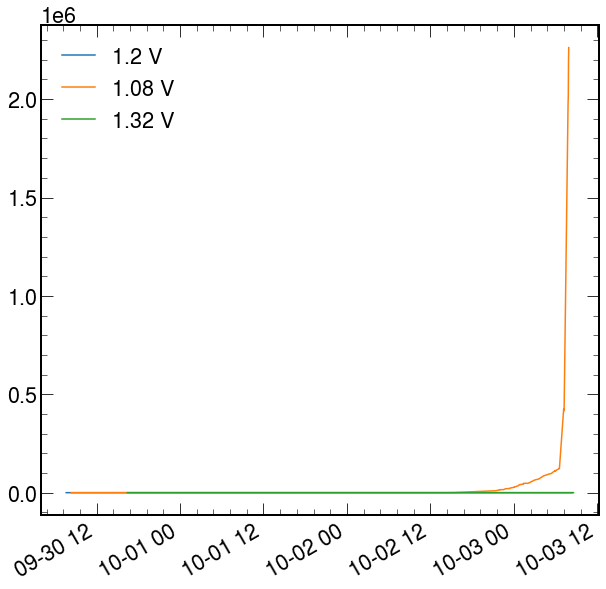

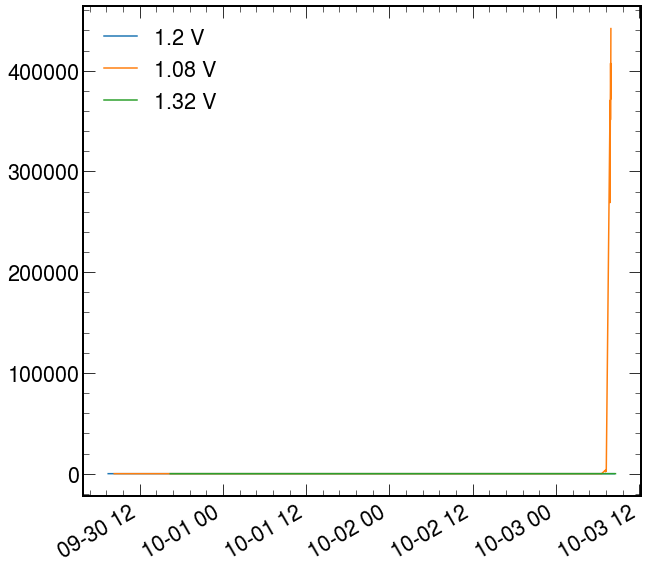

In [6]:
ax=dfErr.loc[(dfErr.voltage==1.2)&dfErr.isI2C].plot(y='nErr',label='1.2 V')
dfErr.loc[(dfErr.voltage==1.08)&dfErr.isI2C].plot(y='nErr',label='1.08 V',ax=ax)
dfErr.loc[(dfErr.voltage==1.32)&dfErr.isI2C].plot(y='nErr',label='1.32 V',ax=ax)
# plt.ylim(0,1000)

ax=dfErr.loc[(dfErr.voltage==1.2)&(dfErr.nErr<2e8)&~dfErr.isI2C].plot(y='nErr',label='1.2 V')
dfErr.loc[(dfErr.voltage==1.08)&(dfErr.nErr<2e8)&~dfErr.isI2C].plot(y='nErr',label='1.08 V',ax=ax)
dfErr.loc[(dfErr.voltage==1.32)&(dfErr.nErr<2e8)&~dfErr.isI2C].plot(y='nErr',label='1.32 V',ax=ax)
# plt.ylim(-1,10)


<AxesSubplot:>

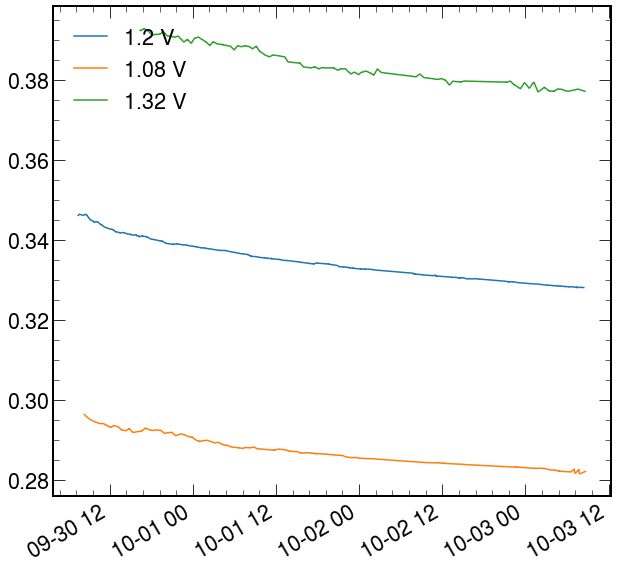

In [7]:
ax=dfErr.loc[dfErr.voltage==1.2].plot(y='current',label='1.2 V')
dfErr.loc[dfErr.voltage==1.08].plot(y='current',label='1.08 V',ax=ax)
dfErr.loc[dfErr.voltage==1.32].plot(y='current',label='1.32 V',ax=ax)


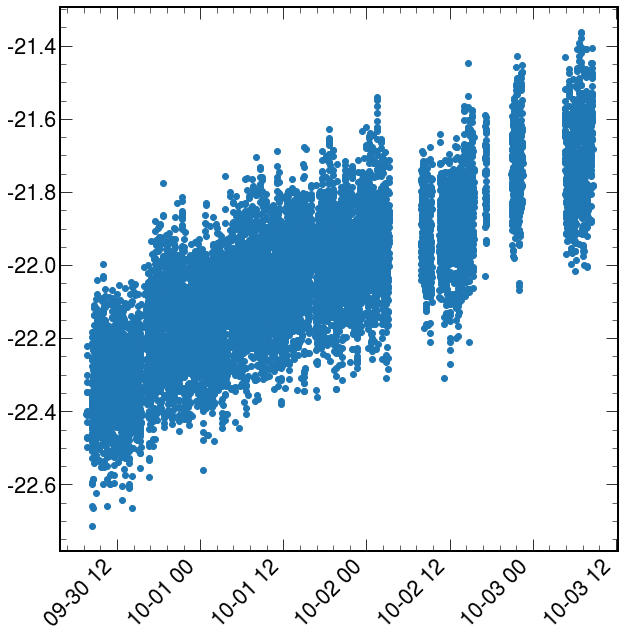

In [8]:
plt.scatter(dfErr.index,dfErr.temp)
plt.xticks(rotation=45, ha='right');